In [96]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Loading the data

In [81]:
df = pd.read_csv('data/hotmart_ml_test.csv', sep=',', encoding='utf-8')
df = df.set_index('id', drop=True)
df.head(5)

,c1,c2,c3,c4,c5,c6,variant,n1,n2,n3,...,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14
id,,,,,,,,,,,,,,,,,,,,,
0,R0I,YW5kc,ZXM,NaN,True,LTA0OjAw,A,147.175163,508.833307,1.373772,...,198.480790,1.513241e+09,0.877958,563.317119,18.827356,0.111096,0.910215,0.270997,38.999087,0.073268
1,QVI,aW9z,cHQ,aHVhd,True,KzAzOjAw,B,288.359771,1028.901212,13.839420,...,384.252343,7.030908e+08,7.915538,1059.667759,NaN,0.360950,2.965243,0.349473,77.952363,0.185909
2,SVQ,aW9z,ZXM,NaN,True,LTA1OjAw,A,186.063223,650.402814,2.372309,...,249.778061,5.050894e+09,1.573227,700.112963,NaN,0.155331,1.327952,0.140478,49.276629,0.097967
3,R0I,YW5kc,ZXM,NaN,True,LTA0OjAw,A,144.562911,499.384425,0.010756,...,195.028589,2.703625e+09,0.843725,554.100930,NaN,0.108525,0.885378,0.152239,38.323737,0.071742
4,QlI,YW5kc,ZW4,YXBwb,True,NaN,A,77.314738,259.654122,26.709407,...,105.726136,-1.728980e-01,0.274720,313.339044,10.028185,0.054445,0.363698,1.058591,21.585558,0.037120


### Verify missing values

In [82]:
df.isnull().sum() / df.shape[0] * 100

c1          9.892
c2         10.114
c3          0.000
c4         15.110
c5          0.000
c6         10.174
variant     0.000
n1          0.000
n2          0.000
n3          0.000
n4          0.000
n5          0.000
n6          0.000
n7          0.000
n8          0.000
n9         95.486
n10         0.000
n11         0.000
n12         0.000
n13         0.000
n14         0.000
dtype: float64

- Podemos ver claramente que temos alguns valores faltantes nas variáveis que são categóricas do usuário
- Além disso temos a variável `n9` que representa uma feature numérica coletada antes do experimento que também possui valores faltantes
- Vamos verificar se a variavel `n9` é dependente do tipo de experimento que foi feito (como é algo obtido anteriormente não deveria acontecer)

In [83]:
print(f"Vartiant A - n9 missing: {(df[df['variant'] == 'A']['n9'].isnull().sum() / df[df['variant'] == 'A'].shape[0] * 100):.2f}")
print(f"Vartiant B - n9 missing: {(df[df['variant'] == 'B']['n9'].isnull().sum() / df[df['variant'] == 'B'].shape[0] * 100):.2f}")

Vartiant A - n9 missing: 95.45
Vartiant B - n9 missing: 95.58


- Não conseguimos encontrar uma relação entre a variável `n9` e o tipo de experimento como esperado, podemos prosseguir com a análise
- Como temos uma grande porcentagem de valores faltantes e `n9` é uma variável numérica, vamos verificar se ela é significativa para o modelo

In [84]:
df[['n9', 'n14']].dropna().corr('pearson')

,n9,n14
n9,1.000000,0.100089
n14,0.100089,1.000000


In [85]:
df[['n9', 'n14']].dropna().corr('spearman')

,n9,n14
n9,1.0,1.0
n14,1.0,1.0


<Axes: xlabel='n9', ylabel='n14'>

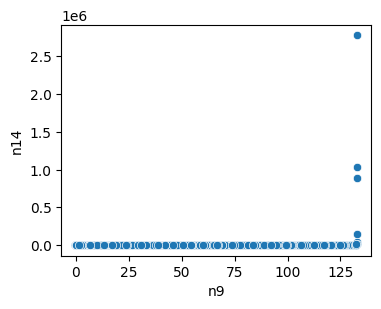

In [86]:
plt.figure(figsize=(4, 3))
sns.scatterplot(x='n9', y='n14', data=df[['n9', 'n14']].dropna())


- A corelação de  pearson de `n9` com a variável target `n14` é baixa
- Na correlação de spearman temos uma correlação alta, mas pode ser por conta de outliers

<Axes: xlabel='variant', ylabel='n14'>

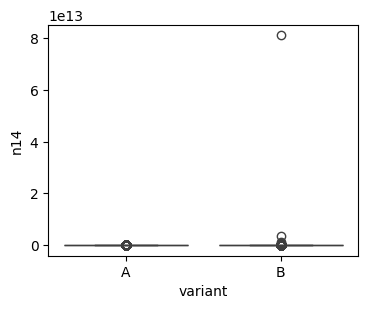

In [87]:
plt.figure(figsize=(4, 3))
sns.boxplot(x='variant', y='n14', data=df)

<Axes: xlabel='variant', ylabel='n14'>

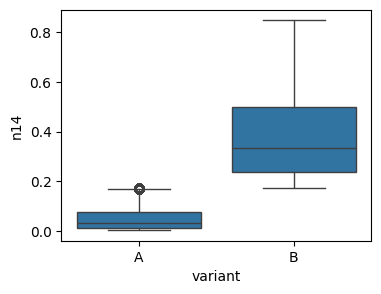

In [88]:
q_min = df['n14'].quantile(0.1)
q_max = df['n14'].quantile(0.9)

plt.figure(figsize=(4, 3))
sns.boxplot(x='variant', y='n14', data=df[(df['n14'] > q_min) & (df['n14'] < q_max)])

<Axes: xlabel='n9', ylabel='n14'>

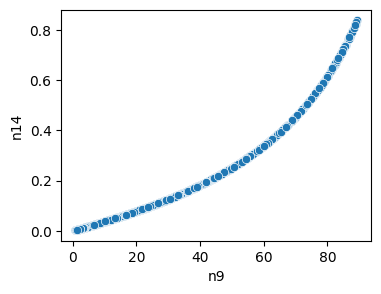

In [89]:
plt.figure(figsize=(4, 3))
sns.scatterplot(x='n9', y='n14', data=df[(df['n14'] > q_min) & (df['n14'] < q_max)][['n9', 'n14']].dropna())


- A correlação de spearman de `n9` com a variável target `n14` é perfeira (1), pode ser uma variável muito importante para o modelo ou algo que foi gerado artificialmente a partir da variável target
- Vamos verificar as variaveis categoricas faltantes

In [90]:
target = 'n14'
categoricas = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6']

In [91]:
#Numermo de categorias
for col in categoricas:
    print(f"{col}: {df[col].nunique()}")

c1: 174
c2: 4
c3: 29
c4: 268
c5: 2
c6: 35


- Primeiro iremos verificar as variáveis categóricas que possuem poucas categorias

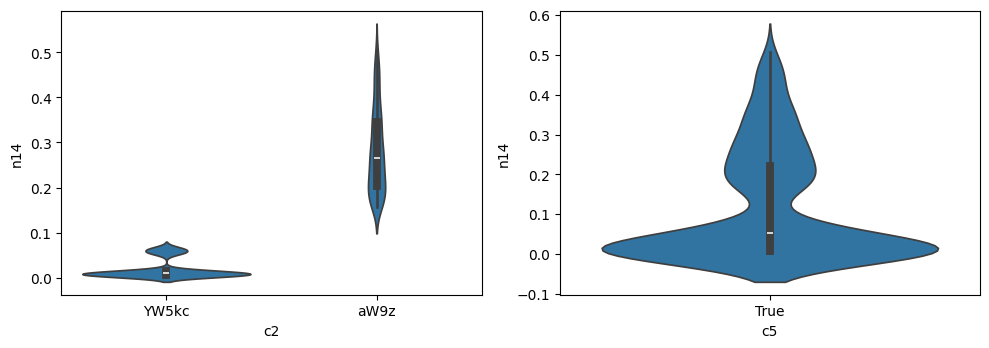

In [97]:
fig = plt.figure(figsize=(10, 10))
for i, col in enumerate(['c2', 'c5']):
    fig.add_subplot(3, 2, i+1)
    sns.violinplot(x=col, y=target, data=df[(df['n14'] > q_min) & (df['n14'] < q_max)].dropna())
    fig.tight_layout()

- Podemos perceber que a redulção da imagem de `n14` também representa uma do domínio das variáveis categóricas, ou seja, c5 por exemplo pode representar se o usuário realizou uma compra ou não (caso < `q_min`) ou uma empresa ou comprador em atacado (caso > `q_max`), e como ela não tem valores faltantes podemos considerar uma variável importante para o modelo

# TODO
- Verificar outros valores para c2

In [106]:
print(f"c5 Falso: {df[df['c5'] == False]['n14'].mean():.2f}")
print(f"c5 Verdadeiro: {df[df['c5'] == True]['n14'].mean():.2f}")

c5 Falso: 1993694647981.05
c5 Verdadeiro: 9.28


- Vamos verificar agora as colunas categóricas com muitas categorias

In [134]:
_df = df.copy()
_df['c1'].fillna('NAN', inplace=True)
_df.groupby('c1')[['n14']].mean().sort_values(by='n14', ascending=False)

,n14
c1,
UEc,2.179115e+13
Vkk,1.808045e+11
R0Q,1.131567e+10
Q0Q,3.667998e+09
VEw,1.516742e+08
...,...
VFI,4.237430e-02
QlI,3.407673e-02
NAN,2.258934e-02


In [136]:
_df = df.copy()
_df['c4'].fillna('NAN', inplace=True)
_df.groupby('c4')[['n14']].mean().sort_values(by='n14', ascending=False)

,n14
c4,
YWxpZ,2.179115e+13
bnV1,1.808045e+11
YXhpb,1.131567e+10
YmF1a,3.667998e+09
ZG9yb,1.516742e+08
...,...
eGlhb,2.410788e-01
aHVhd,1.808581e-01
NAN,1.047684e-01


In [137]:
del _df

- Podemos ver que em ambos os casos a média das variáveis NAN é bem a baixo do resto de outros valores, portanto não acredito ser uma boa ideia substituir pela média total
- Agora iremos verificar `c6` que não havia entrado na análise anterior

In [142]:
_df = df.copy()
_df['c6'].fillna('NAN', inplace=True)
_df.groupby('c6')[['n14']].mean().sort_values(by='n14', ascending=False).tail(5)

,n14
c6,
LTA0OjAw,0.065845
NAN,0.039564
ZWdhbF9zdHJp,0.021358
KzA1OjMw,0.009290
KzAyOjAw,0.001950


- Podemos ver novamente que os valores faltantes de `c6` possuem uma média bem abaixo do resto, portanto podemos pensar em algum método como um modelo próprio de classificação para preencher os valores faltantes